# GIAI ĐOẠN:  VECTORIZATION & TOPIC MODELING

<h3> VECTORIZATION: CountVectorizer cho 4 mô hình ML (LDA, LSA, K-Means, HAC)

<H4> CÁC THƯ VIỆN CẦN THIẾT 

In [8]:
!pip install pandas numpy scikit-learn gensim pyLDAvis wordcloud matplotlib seaborn python-Levenshtein underthesea

<H4> SỬ DỤNG THƯ VIỆN

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import os
warnings.filterwarnings('ignore')

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer

# Topic Modeling & Clustering
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering

# Visualization
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

# Metrics
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
import Levenshtein

## LOAD DỮ LIỆU 

#### CẤU HÌNH cho vector hoá và thống kê 

In [10]:
INPUT_CSV = r"C:\Users\ADMIN\python\NLP-final\Data\final_data.csv"
N_TOPICS = 15
N_TOP_WORDS = 15  # Số từ đại diện cho mỗi topic
RANDOM_STATE = 42

In [11]:
# Tạo thư mục BoW
OUTPUT_DIR = r"C:\Users\ADMIN\python\NLP-final\Output\BoW"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [12]:
df = pd.read_csv(INPUT_CSV)
print(f"✓ Đã load {len(df)} documents")
print(f"✓ Các cột: {list(df.columns)}")

✓ Đã load 2389 documents
✓ Các cột: ['description', 'category']


In [13]:
print(f"\nThống kê category:")
print(df['category'].value_counts())


Thống kê category:
category
Tin mới         1657
Xe               249
Thế giới          86
Pháp luật         80
Thời sự           72
Giải trí          59
Thể thao          51
Kinh doanh        35
Xã hội            24
Bóng đá           16
Giáo dục          13
Sức khỏe          10
Công nghệ          8
Chính trị          6
Văn hóa            5
Du lịch            5
Đời sống           4
Bất động sản       4
Số hóa             3
Khoa học           2
Name: count, dtype: int64


#### Sử dụng description để làm topic modeling

In [14]:
documents = df['description'].tolist()
print(f"\n✓ Sẽ dùng {len(documents)} documents cho topic modeling")


✓ Sẽ dùng 2389 documents cho topic modeling


### VECTORIZATION - BAG OF WORDS (CountVectorizer)

#### Tạo CountVectorizer

In [15]:
vectorizer = CountVectorizer(
    max_features=5000,      # Giới hạn 5000 từ 
    min_df=5,               # Từ phải xuất hiện ít nhất 5 documents
    max_df=0.7,             # Từ không xuất hiện quá 70% documents
    ngram_range=(1, 2)      # Unigram và bigram
)
doc_term_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

In [16]:
print(f" Document-Term Matrix shape: {doc_term_matrix.shape}")
print(f"  - Số documents: {doc_term_matrix.shape[0]}")
print(f"  - Số features (từ): {doc_term_matrix.shape[1]}")
print(f"  - Sparsity: {(1 - doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1])) * 100:.2f}%")
print(f"\n Sẽ dùng matrix này cho CẢ 4 models: LDA, NMF, K-Means, HAC")

 Document-Term Matrix shape: (2389, 5000)
  - Số documents: 2389
  - Số features (từ): 5000
  - Sparsity: 98.19%

 Sẽ dùng matrix này cho CẢ 4 models: LDA, NMF, K-Means, HAC


In [17]:
# Lấy feature names
feature_names = vectorizer.get_feature_names_out()
print(f"\nVí dụ features: {list(feature_names[:20])}")


Ví dụ features: ['a_bank', 'air', 'album', 'an_giang', 'an_khánh', 'an_ninh', 'an_ninh mạng', 'an_ninh quốc_gia', 'an_ninh trật_tự', 'an_ninh điều_tra', 'an_ninh_mạng', 'an_ninh_mạng phòng_chống', 'an_ninh_mạng quốc_gia', 'an_sinh', 'an_sinh xã_hội', 'an_toàn', 'an_toàn chạy_tàu', 'an_toàn công_trình', 'an_toàn giao_thông', 'an_toàn thực_phẩm']


## XÂY DỰNG 4 MODELS (LDA, LSA, K-Means, HAC)

In [18]:
# XÂY DỰNG 4 MODELS
models = {}
doc_topic_distributions = {}

### MODEL 1: LDA (Latent Dirichlet Allocation)

In [19]:
print("\n[3] Training LDA Model...")
lda_model = LatentDirichletAllocation(
    n_components=N_TOPICS,
    max_iter=50,
    learning_method='online',
    random_state=RANDOM_STATE,
    batch_size=128,
    n_jobs=-1,
    verbose=0
)
lda_output = lda_model.fit_transform(doc_term_matrix)
models['LDA'] = lda_model
doc_topic_distributions['LDA'] = lda_output

print(f"LDA trained - Perplexity: {lda_model.perplexity(doc_term_matrix):.2f}")


[3] Training LDA Model...
LDA trained - Perplexity: 824.90


### MODEL 2: LSA (Latent Semantic Analysis / Truncated SVD)

In [20]:
print("\n[3.2] Training LSA Model...")
lsa_model = TruncatedSVD(
    n_components=N_TOPICS,
    algorithm='randomized',
    n_iter=100,
    random_state=RANDOM_STATE
)
lsa_output = lsa_model.fit_transform(doc_term_matrix)
models['LSA'] = lsa_model
doc_topic_distributions['LSA'] = lsa_output

# Normalize LSA output to get pseudo-probabilities
lsa_output_normalized = np.abs(lsa_output)
lsa_output_normalized = lsa_output_normalized / lsa_output_normalized.sum(axis=1, keepdims=True)
doc_topic_distributions['LSA'] = lsa_output_normalized

explained_var = lsa_model.explained_variance_ratio_.sum()
print(f"✓ LSA trained - Explained variance: {explained_var*100:.2f}%")


[3.2] Training LSA Model...
✓ LSA trained - Explained variance: 34.50%


### MODEL 3: K-Means

In [21]:
print("\n[3.3] Training K-Means Model...")
kmeans_model = KMeans(
    n_clusters=N_TOPICS,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=RANDOM_STATE
)
kmeans_labels = kmeans_model.fit_predict(doc_term_matrix)
models['KMeans'] = kmeans_model

# Tạo pseudo document-topic distribution từ distances
kmeans_distances = kmeans_model.transform(doc_term_matrix)
# Convert distances thành probabilities (inverse distance)
kmeans_probs = 1 / (1 + kmeans_distances)
kmeans_probs = kmeans_probs / kmeans_probs.sum(axis=1, keepdims=True)
doc_topic_distributions['KMeans'] = kmeans_probs

print(f"✓ K-Means trained - Inertia: {kmeans_model.inertia_:.2f}")


[3.3] Training K-Means Model...
✓ K-Means trained - Inertia: 2279992.99


### MODEL 4: HAC (Hierarchical Agglomerative Clustering)

In [22]:
print("\n[3.4] Training HAC Model...")
hac_model = AgglomerativeClustering(
    n_clusters=N_TOPICS,
    metric='cosine',
    linkage='average'
)
hac_labels = hac_model.fit_predict(doc_term_matrix.toarray())
models['HAC'] = hac_model

# Tạo pseudo distribution cho HAC (one-hot encoding)
hac_probs = np.zeros((len(hac_labels), N_TOPICS))
hac_probs[np.arange(len(hac_labels)), hac_labels] = 1
doc_topic_distributions['HAC'] = hac_probs

print(f"✓ HAC trained")


[3.4] Training HAC Model...
✓ HAC trained


## BƯỚC 4: TRÍCH XUẤT TOP WORDS CHO MỖI MODEL

In [23]:
print("\n" + "="*80)
print("BƯỚC 4: TOP WORDS CHO MỖI MODEL")
print("="*80)

def get_top_words_from_components(components, feature_names, n_top_words):
    """Lấy top words từ component matrix (LDA/NMF)"""
    topics_words = []
    for topic_idx, topic in enumerate(components):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

def get_top_words_from_centroids(model, vectorizer, n_top_words):
    """Lấy top words từ cluster centroids (K-Means)"""
    topics_words = []
    feature_names = vectorizer.get_feature_names_out()
    for centroid in model.cluster_centers_:
        top_indices = centroid.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

def get_top_words_from_labels(matrix, labels, vectorizer, n_clusters, n_top_words):
    """Lấy top words từ labels (HAC)"""
    topics_words = []
    feature_names = vectorizer.get_feature_names_out()
    
    for cluster_id in range(n_clusters):
        cluster_docs = matrix[labels == cluster_id]
        if cluster_docs.shape[0] > 0: 
            # Tính trung bình TF-IDF trong cluster
            centroid = cluster_docs.mean(axis=0).A1
            top_indices = centroid.argsort()[-n_top_words:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            topics_words.append(top_words)
        else:
            topics_words.append([])
    
    return topics_words



BƯỚC 4: TOP WORDS CHO MỖI MODEL


In [24]:
# Trích xuất top words
all_topics_words = {}

In [25]:
print("\n[4.1] LDA Top Words:")
all_topics_words['LDA'] = get_top_words_from_components(
    lda_model.components_, feature_names, N_TOP_WORDS
)
for idx, words in enumerate(all_topics_words['LDA']):
    print(f"  Topic {idx}: {', '.join(words[:8])}")


[4.1] LDA Top Words:
  Topic 0: doanh_nghiệp, đăng_ký, kỳ, hoạt_động, vốn, thành_lập, xuất_hành, vốn đăng_ký
  Topic 1: giải, thưởng, trúng, lũ, công_ty, giải giải, sông, điện
  Topic 2: giá, thị_trường, ngân_hàng, giao_dịch, mua, lãi_suất, phiên, việt_nam
  Topic 3: mưa, nhiệt_độ, rét, khu_vực, biển, dông, dự_báo, trời
  Topic 4: vietlott, chủ_nhật, cập_nhật, huế, xspy, giá, chi_tiết, phú_yên
  Topic 5: nuôi, học_sinh, thông_tin, trường, dự_án, tiền, xã_hội, dạy
  Topic 6: trận, việt_nam, philippines, nữ, bóng, đội, đấu, huấn_luyện_viên
  Topic 7: khu_vực, trung_quốc, mỹ, campuchia, ukraine, biên_giới, tổng_thống, nga
  Topic 8: người_dân, đất, khu_vực, hộ, địa_phương, ban_nhân_dân, tuyến, gia_đình
  Topic 9: công_an, tiền, đối_tượng, cơ_quan, điều_tra, án, tài_khoản, quy_định
  Topic 10: việt_nam, phát_triển, hoạt_động, chương_trình, doanh_nghiệp, thành_phố, tổ_chức, kinh_tế
  Topic 11: trung_ương, dự_án, phát_triển, quốc_hội, đại_biểu, kinh_tế, nghị_quyết, quy_định
  Topic 12: vàng

In [26]:
print("\n[4.2] LSA Top Words:")
all_topics_words['LSA'] = get_top_words_from_components(
    lsa_model.components_, feature_names, N_TOP_WORDS
)
for idx, words in enumerate(all_topics_words['LSA']):
    print(f"  Topic {idx}: {', '.join(words[:8])}")



[4.2] LSA Top Words:
  Topic 0: mưa, nhiệt_độ, rét, dông, nhất_độ, nhiệt_độ nhất_độ, rải_rác, mưa_rào
  Topic 1: giá, trung_ương, vàng, dự_án, việt_nam, doanh_nghiệp, phát_triển, tổ_chức
  Topic 2: giá, vàng, giá vàng, mua, niêm_yết, phiên, giao_dịch, cập_nhật
  Topic 3: vietlott, giải, vietlott vietlott, power, thưởng, trúng, giải giải, vietlott power
  Topic 4: giải, giải giải, thưởng, trúng, giải trúng, trúng giải, trị_giá, vé
  Topic 5: doanh_nghiệp, đăng_ký, kỳ, vốn, thành_lập, vốn đăng_ký, hoạt_động, doanh_nghiệp thành_lập
  Topic 6: vàng, giá vàng, mua, trung_ương, phiên, dự_án, đồng_lượng, sjc
  Topic 7: giá, dự_án, đại_biểu, trung_ương, quốc_hội, cập_nhật, chi_tiết, viết
  Topic 8: ngân_hàng, thị_trường, lãi_suất, nhà_nước, kinh_tế, ngân_hàng nhà_nước, chính_sách, ổn_định
  Topic 9: việt_nam, trận, nữ, philippines, vàng, bóng, nữ việt_nam, đội_tuyển
  Topic 10: dự_án, trung_ương, việt_nam, trận, nữ, philippines, tuyến, nuôi
  Topic 11: đường_sắt, giao_thông, nhất_độ, công_an,

In [27]:
print("\n[4.3] K-Means Top Words:")
all_topics_words['KMeans'] = get_top_words_from_centroids(
    kmeans_model, vectorizer, N_TOP_WORDS
)
for idx, words in enumerate(all_topics_words['KMeans']):
    print(f"  Topic {idx}: {', '.join(words[:8])}")


[4.3] K-Means Top Words:
  Topic 0: trận, việt_nam, philippines, nữ, bóng, nữ việt_nam, huấn_luyện_viên, đấu
  Topic 1: trung_ương, dự_án, phát_triển, đại_biểu, tổ_chức, thành_phố, xây_dựng, quốc_hội
  Topic 2: mưa, nhất_độ, nhiệt_độ, nhiệt_độ nhất_độ, mây, rét, mưa_rào, dông
  Topic 3: chủ_nhật, huế, xspy, vietlott, phú_yên, xstth, đà_nẵng, quảng_ngãi
  Topic 4: việt_nam, doanh_nghiệp, hoạt_động, khu_vực, thành_phố, công_an, tổ_chức, trung_ương
  Topic 5: giải, giải giải, thưởng, trúng, trị_giá, giải trúng, giải trị_giá, trúng giải
  Topic 6: không_khí, ô_nhiễm, hà_nội, chất_lượng, chỉ_số, môi_trường, chất_lượng không_khí, ô_nhiễm không_khí
  Topic 7: mưa, rét, khu_vực, dự_báo, biển, thời_tiết, dông, trung_bộ
  Topic 8: vietlott, vietlott vietlott, power, vietlott power, power vietlott, h_tra, h_tra vietlott, mega
  Topic 9: giá, cập_nhật, chi_tiết, viết, hãng, dòng, việt_nam, cập_nhật chi_tiết
  Topic 10: đường_sắt, giao_thông, an_toàn, km, xây_dựng, lối, km km, giao_thông đường_sắt

In [28]:
print("\n[4.4] HAC Top Words:")
all_topics_words['HAC'] = get_top_words_from_labels(
    doc_term_matrix, hac_labels, vectorizer, N_TOPICS, N_TOP_WORDS
)
for idx, words in enumerate(all_topics_words['HAC']):
    print(f"  Topic {idx}: {', '.join(words[:8])}")


[4.4] HAC Top Words:
  Topic 0: trung_ương, dự_án, doanh_nghiệp, phát_triển, tổ_chức, thành_phố, kinh_tế, hoạt_động
  Topic 1: bé, tin_tức, công_ty, chó, trẻ, bệnh_viện, công_nghiệp, thông_tin
  Topic 2: công_an, giao_thông, đường_sắt, tiền, lực_lượng, cảnh_sát, an_toàn, thông_tin
  Topic 3: mưa, nhiệt_độ, khu_vực, biển, rét, dông, dự_báo, trời
  Topic 4: hoa, trà, núi, rùa, loài, dầu, giúp, tự_nhiên
  Topic 5: nga, tổng_thống, khu_vực, thái_lan, ukraine, mỹ, quốc_gia, campuchia
  Topic 6: việt_nam, trận, philippines, nữ, bóng, đội, huấn_luyện_viên, đấu
  Topic 7: vietlott, giải, chủ_nhật, thưởng, huế, xspy, trúng, phú_yên
  Topic 8: album, mùa, thu, hoạt_động, phát_sóng, cân_nhắc, thành_viên, dừng
  Topic 9: giá, vàng, thị_trường, mua, ngân_hàng, giá vàng, cập_nhật, giao_dịch
  Topic 10: phim, khán_giả, diễn_viên, sống, trung_ương, nữ, hình_ảnh, cảm_xúc
  Topic 11: đậu, chuyên_gia, giàu, nguy_cơ, chất, thực_phẩm, tử_vong, giúp
  Topic 12: bay, hãng, hàng_không, ấn_độ, sân_bay, máy_ba

GÁN TOPIC/CLUSTER CHO MỖI DOCUMENT

In [29]:
# LDA
df['topic_LDA'] = lda_output.argmax(axis=1)
df['topic_prob_LDA'] = lda_output.max(axis=1)

In [30]:
# LSA
df['topic_LSA'] = lsa_output_normalized.argmax(axis=1)
df['topic_prob_LSA'] = lsa_output_normalized.max(axis=1)

In [31]:
# K-Means
df['topic_KMeans'] = kmeans_labels
df['topic_prob_KMeans'] = kmeans_probs.max(axis=1)

In [32]:
# HAC
df['topic_HAC'] = hac_labels
df['topic_prob_HAC'] = 1.0

## BƯỚC 5: SINH CAPTION CHO MỖI TOPIC (4 MODELS)

In [33]:
from underthesea import word_tokenize, pos_tag, ner
from collections import Counter

In [34]:
def clean_word(word):
    """Loại bỏ dấu _ và làm sạch từ"""
    return word.replace('_', ' ').strip()
def is_valid_entity(entity):
    """Kiểm tra entity có hợp lệ không"""
    # Loại bỏ entities quá dài hoặc quá ngắn
    words = entity.split()
    if len(words) < 2 or len(words) > 7:
        return False
    return True

In [35]:
def analyze_documents_for_topic(df, model_name, topic_id, top_n_docs=50):
    """
    Lấy các document thuộc topic → phân tích POS/NER → trích xuất keywords
    """
    # Lấy documents thuộc topic này
    topic_docs = df[df[f'topic_{model_name}'] == topic_id]['description'].head(top_n_docs)
    
    # Tách từ và gán nhãn từ loại
    nouns = []
    entities = []
    
    for doc in topic_docs:
        try:
            # POS tagging - Lấy danh từ
            pos_tags = pos_tag(doc)
            doc_nouns = [
                clean_word(word) for word, tag in pos_tags
                if tag in ['N', 'Np', 'Nc'] and len(word) > 2
            ]
            nouns.extend(doc_nouns)
            
            # NER (Named Entity Recognition)
            ner_tags = ner(doc)
            
            current_entity = []
            current_type = None
            
            for token, pos, chunk, ner_tag in ner_tags:
                if ner_tag.startswith('B-'):
                    # Lưu entity cũ nếu có
                    if current_entity:
                        entity_text = ' '.join(current_entity)
                        entity_clean = clean_word(entity_text)
                        if is_valid_entity(entity_clean):
                            entities.append(entity_clean)
                    
                    # Bắt đầu entity mới
                    current_entity = [clean_word(token)]
                    current_type = ner_tag[2:]
                
                elif ner_tag.startswith('I-') and current_type == ner_tag[2:]:
                    # Tiếp tục entity
                    current_entity.append(clean_word(token))
                
                else:
                    # Kết thúc entity
                    if current_entity:
                        entity_text = ' '.join(current_entity)
                        entity_clean = clean_word(entity_text)
                        if is_valid_entity(entity_clean):
                            entities.append(entity_clean)
                        current_entity = []
                        current_type = None
            
            # Lưu entity cuối cùng
            if current_entity:
                entity_text = ' '.join(current_entity)
                entity_clean = clean_word(entity_text)
                if is_valid_entity(entity_clean):
                    entities.append(entity_clean)
        
        except Exception:
            continue
    
    # Đếm tần suất và lấy top
    top_nouns = [w for w, _ in Counter(nouns).most_common(8)]
    top_entities = [e for e, _ in Counter(entities).most_common(5)]
    
    return top_nouns, top_entities

def generate_smart_caption(top_nouns, top_entities, top_words):
    """
    Sinh caption từ danh từ, thực thể và top words
    """
    # Làm sạch top_words (loại bỏ dấu _)
    top_words_clean = [clean_word(w) for w in top_words]
    
    # Chọn chủ đề chính
    main_subjects = []
    
    # Ưu tiên entities ngắn gọn (2-3 từ)
    if top_entities:
        short_entities = [e for e in top_entities if len(e.split()) <= 3][:2]
        if short_entities:
            main_subjects = short_entities
    
    # Nếu không có entity tốt, dùng danh từ
    if not main_subjects and top_nouns:
        # Ưu tiên danh từ không quá dài
        good_nouns = [n for n in top_nouns if len(n.split()) <= 2][:2]
        main_subjects = good_nouns if good_nouns else top_nouns[:2]
    
    # Lấy từ mô tả bổ sung từ top_words
    # Loại bỏ những từ đã có trong main_subjects
    main_text = ' '.join(main_subjects).lower()
    descriptors = [
        w for w in top_words_clean 
        if w.lower() not in main_text and len(w.split()) <= 2
    ][:3]
    
    # Sinh caption
    if len(main_subjects) >= 2:
        caption = f"{main_subjects[0]} và {main_subjects[1]}"
        if descriptors:
            caption += f" - {', '.join(descriptors[:2])}"
    elif len(main_subjects) == 1:
        caption = f"{main_subjects[0]}"
        if descriptors:
            caption += f" ({', '.join(descriptors[:2])})"
    else:
        # Fallback - chỉ dùng top words
        caption = ', '.join(top_words_clean[:3])
    
    return caption

In [36]:
# Sinh caption cho từng model
smart_captions = {}

for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[5.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] {model_name} Smart Captions:")
    captions = {}
    
    for topic_id in range(N_TOPICS):
        # Phân tích documents
        top_nouns, top_entities = analyze_documents_for_topic(df, model_name, topic_id)
        
        # Top words từ model (làm sạch)
        top_words = all_topics_words[model_name][topic_id][:8]
        
        # Sinh caption
        caption = generate_smart_caption(top_nouns, top_entities, top_words)
        captions[topic_id] = caption
        
        # In kết quả
        print(f"  Topic {topic_id}:")
        print(f"    - Danh từ: {', '.join(top_nouns[:5])}")
        print(f"    - Thực thể: {', '.join(top_entities[:3]) if top_entities else 'N/A'}")
        print(f"    - Caption: {caption}")
    
    smart_captions[model_name] = captions

# Lưu vào CSV
caption_df = pd.DataFrame([
    {'Model': model, 'Topic': topic_id, 'Caption': caption}
    for model, captions in smart_captions.items()
    for topic_id, caption in captions.items()
])
caption_df.to_csv(os.path.join(OUTPUT_DIR, 'smart_captions_all_models.csv'), 
                  index=False, encoding='utf-8-sig')
print(f"\nĐã lưu: {os.path.join(OUTPUT_DIR, 'smart_captions_all_models.csv')}")



[5.1] LDA Smart Captions:
  Topic 0:
    - Danh từ: doanh nghiệp, vốn, hoạt động, thành lập, thủ tục
    - Thực thể: rút lui thị trường, doanh nghiệp rút lui thị trường, hiệu quả chính xác
    - Caption: doanh nghiệp và vốn - đăng ký, kỳ
  Topic 1:
    - Danh từ: điện, giải, vận hành, khánh hòa, đợt
    - Thực thể: thẩm quyền ban nhân dân, nội dung thẩm quyền, hư hỏng tổng thiệt hại ước tính
    - Caption: sông đồng nai (giải, thưởng)
  Topic 2:
    - Danh từ: giá, thị trường, trung quốc, việt nam, lãi suất
    - Thực thể: lá chắn tài chính, hạn chế rủi ro, hong kong trung quốc
    - Caption: vecom st (giá, thị trường)
  Topic 3:
    - Danh từ: biển, trời, dông, dự báo, mưa
    - Thực thể: thiên tai thiệt hại ước tính, trạm khả năng, lốc sét mưa đá gió giật
    - Caption: trạm khả năng (mưa, nhiệt độ)
  Topic 4:
    - Danh từ: chủ nhật, vietlott, tàu, huế, chí minh
    - Thực thể: bến tre bến tre bến tre bnews, bến tre bến tre bến tre xscm, thứ sáu gia lai
    - Caption: mega vietlott

## BƯỚC 6: ĐÁNH GIÁ CHẤT LƯỢNG - 4 MODELS

In [37]:
def calculate_compactness_cosine(doc_vectors, labels):
    """Compactness - Cosine distance"""
    unique_labels = np.unique(labels)
    compactness_scores = []
    
    for label in unique_labels:
        cluster_docs = doc_vectors[labels == label]
        if len(cluster_docs) > 1:
            cos_dist = cosine_distances(cluster_docs)
            n = len(cluster_docs)
            avg_dist = (cos_dist.sum() - n) / (n * (n - 1))
            compactness_scores.append(avg_dist)
    
    return np.mean(compactness_scores)

def calculate_separation_cosine(doc_vectors, labels):
    """Separation - Cosine distance"""
    unique_labels = np.unique(labels)
    centroids = []
    
    for label in unique_labels:
        cluster_docs = doc_vectors[labels == label]
        centroid = cluster_docs.mean(axis=0)
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    cos_dist = cosine_distances(centroids)
    n_clusters = len(unique_labels)
    avg_separation = (cos_dist.sum() - n_clusters) / (n_clusters * (n_clusters - 1))
    
    return avg_separation

In [38]:
# Tính metrics cho tất cả models
evaluation_results = []

In [39]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[6.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] Evaluating {model_name}...")
    
    doc_vectors = doc_topic_distributions[model_name]
    labels = df[f'topic_{model_name}'].values
    
    # Compactness
    compactness = calculate_compactness_cosine(doc_vectors, labels)
    
    # Separation
    separation = calculate_separation_cosine(doc_vectors, labels)
    
    # Silhouette Score
    silhouette = silhouette_score(doc_vectors, labels, metric='cosine')
    
    # Levenshtein
    captions = [smart_captions[model_name][i] for i in range(N_TOPICS)]
    lev_distances = []
    for i in range(len(captions)):
        for j in range(i+1, len(captions)):
            lev_distances.append(Levenshtein.distance(captions[i], captions[j]))
    avg_lev = np.mean(lev_distances) if lev_distances else 0
    
    evaluation_results.append({
        'Model': model_name,
        'Compactness_Cosine': compactness,
        'Separation_Cosine': separation,
        'Silhouette_Cosine': silhouette,
        'Avg_Levenshtein': avg_lev
    })
    
    print(f"  ✓ Compactness: {compactness:.4f}")
    print(f"  ✓ Separation: {separation:.4f}")
    print(f"  ✓ Silhouette: {silhouette:.4f}")
    print(f"  ✓ Levenshtein: {avg_lev:.2f}")

# Tạo DataFrame so sánh
eval_df = pd.DataFrame(evaluation_results)
print("\n" + "="*80)
print("📊 BẢNG SO SÁNH 4 MODELS:")
print("="*80)
print(eval_df.to_string(index=False))

# Lưu file
eval_df.to_csv(os.path.join(OUTPUT_DIR, 'comparison_all_models.csv'), index=False)
print(f"\n✓ Đã lưu: {os.path.join(OUTPUT_DIR, 'comparison_all_models.csv')}")


[6.1] Evaluating LDA...
  ✓ Compactness: 0.1469
  ✓ Separation: 0.8433
  ✓ Silhouette: 0.7043
  ✓ Levenshtein: 32.29

[6.2] Evaluating LSA...
  ✓ Compactness: 0.0970
  ✓ Separation: 0.4147
  ✓ Silhouette: 0.2878
  ✓ Levenshtein: 35.72

[6.3] Evaluating KMeans...
  ✓ Compactness: -0.0249
  ✓ Separation: 0.1051
  ✓ Silhouette: 0.0912
  ✓ Levenshtein: 33.10

[6.4] Evaluating HAC...
  ✓ Compactness: -0.0414
  ✓ Separation: 0.9286
  ✓ Silhouette: 0.9996
  ✓ Levenshtein: 30.82

📊 BẢNG SO SÁNH 4 MODELS:
 Model  Compactness_Cosine  Separation_Cosine  Silhouette_Cosine  Avg_Levenshtein
   LDA            0.146875           0.843252           0.704331        32.285714
   LSA            0.096988           0.414681           0.287757        35.723810
KMeans           -0.024881           0.105109           0.091205        33.095238
   HAC           -0.041450           0.928571           0.999581        30.819048

✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\BoW\comparison_all_models.csv


In [40]:
# Tạo DataFrame so sánh
eval_df = pd.DataFrame(evaluation_results)
print("\n" + "="*80)
print("📊 BẢNG SO SÁNH 4 MODELS:")
print("="*80)
print(eval_df.to_string(index=False))

# Lưu file
eval_df.to_csv(os.path.join(OUTPUT_DIR, 'comparison_all_models.csv'), index=False)
print(f"\n✓ Đã lưu: {os.path.join(OUTPUT_DIR, 'comparison_all_models.csv')}")


📊 BẢNG SO SÁNH 4 MODELS:
 Model  Compactness_Cosine  Separation_Cosine  Silhouette_Cosine  Avg_Levenshtein
   LDA            0.146875           0.843252           0.704331        32.285714
   LSA            0.096988           0.414681           0.287757        35.723810
KMeans           -0.024881           0.105109           0.091205        33.095238
   HAC           -0.041450           0.928571           0.999581        30.819048

✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\BoW\comparison_all_models.csv


## BƯỚC 8: TRỰC QUAN HÓA - WORDCLOUD CHO 4 MODELS

In [41]:
def create_wordcloud_for_model(model_name, topics_words, n_topics):
    """Tạo WordCloud cho 1 model"""
    n_cols = 2
    n_rows = (n_topics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_topics > 1 else [axes]
    
    for idx in range(n_topics):
        # Tạo word frequency dict
        words = topics_words[idx]
        word_freq = {word: len(words) - i for i, word in enumerate(words)}
        
        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            colormap='viridis',
            max_words=50
        ).generate_from_frequencies(word_freq)
        
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'Topic {idx}: {smart_captions[model_name][idx][:50]}...', 
                           fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    for idx in range(n_topics, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{model_name} - WordClouds', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'wordclouds_{model_name}.png'), 
                dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: wordclouds_{model_name}.png")
    plt.close()

In [42]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[7.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] Tạo WordCloud cho {model_name}...")
    create_wordcloud_for_model(model_name, all_topics_words[model_name], N_TOPICS)


[7.1] Tạo WordCloud cho LDA...
✓ Đã lưu: wordclouds_LDA.png

[7.2] Tạo WordCloud cho LSA...
✓ Đã lưu: wordclouds_LSA.png

[7.3] Tạo WordCloud cho KMeans...
✓ Đã lưu: wordclouds_KMeans.png

[7.4] Tạo WordCloud cho HAC...
✓ Đã lưu: wordclouds_HAC.png


## BƯỚC 9: pyLDAvis (CHỈ CHO LDA)

In [43]:
print("⏳ Đang tạo pyLDAvis...")
vis_data = pyLDAvis.lda_model.prepare(
    lda_model, 
    doc_term_matrix, 
    vectorizer,
    mds='tsne',
    sort_topics=False
)
pyLDAvis.save_html(vis_data, os.path.join(OUTPUT_DIR, 'lda_visualization.html'))
print(f"✓ Đã lưu: {os.path.join(OUTPUT_DIR, 'lda_visualization.html')}")

⏳ Đang tạo pyLDAvis...
✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\BoW\lda_visualization.html


## BƯỚC 10: SO SÁNH TRỰC QUAN

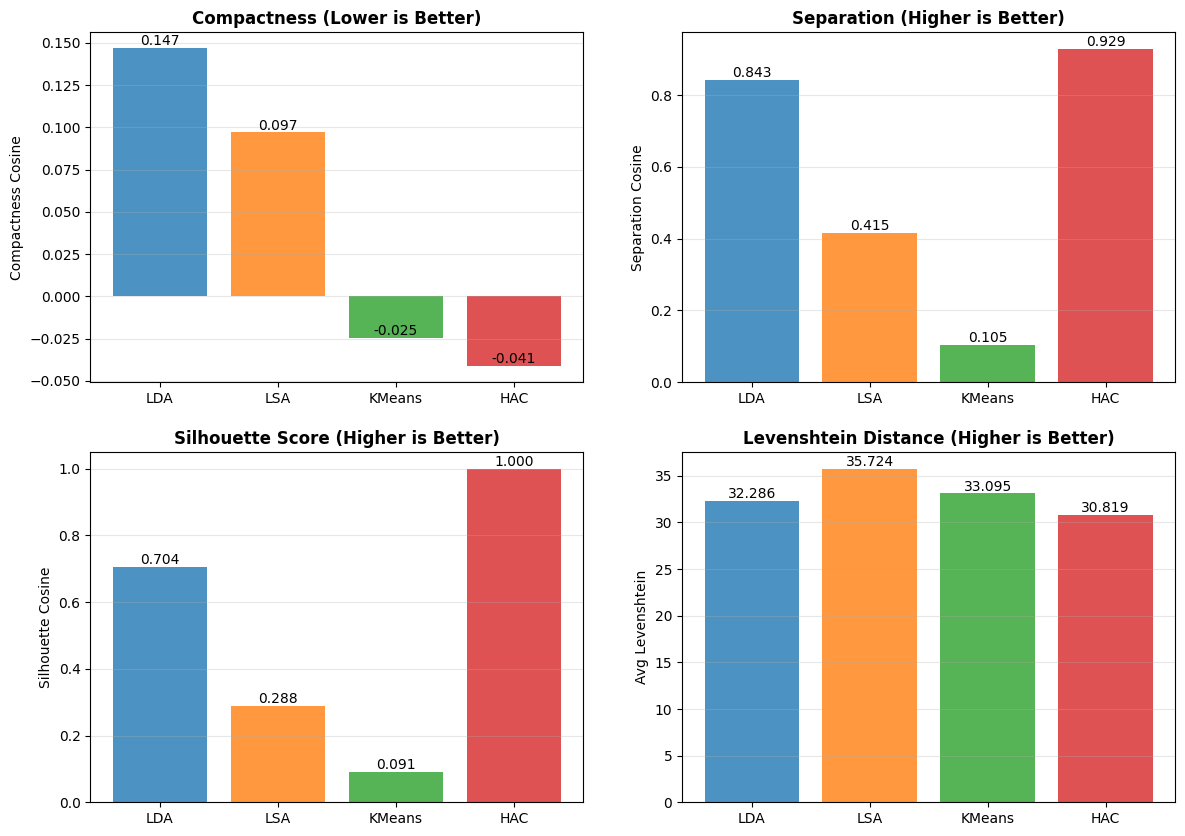

In [44]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Compactness_Cosine', 'Separation_Cosine', 'Silhouette_Cosine', 'Avg_Levenshtein']
titles = ['Compactness (Lower is Better)', 'Separation (Higher is Better)', 
          'Silhouette Score (Higher is Better)', 'Levenshtein Distance (Higher is Better)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = ax.bar(eval_df['Model'], eval_df[metric], color=colors, alpha=0.8)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.replace('_', ' '))
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

In [45]:
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'comparison_metrics_chart.png'), 
            dpi=300, bbox_inches='tight')
print(f"Đã lưu: {os.path.join(OUTPUT_DIR, 'comparison_metrics_chart.png')}")
plt.show()

Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\BoW\comparison_metrics_chart.png


<Figure size 640x480 with 0 Axes>

=============================================================================
### BƯỚC 11: XUẤT KẾT QUẢ CUỐI CÙNG
=============================================================================

In [46]:
# Lưu data với tất cả topic assignments
df.to_csv(os.path.join(OUTPUT_DIR, 'final_data_with_all_topics.csv'), 
          index=False, encoding='utf-8-sig')
print(f"Đã lưu: final_data_with_all_topics.csv")

# Tạo summary cho từng model
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    summary_data = []
    for idx in range(N_TOPICS):
        n_docs = (df[f'topic_{model_name}'] == idx).sum()
        top_words = ', '.join(all_topics_words[model_name][idx][:5])
        
        summary_data.append({
            'Topic': idx,
            'Caption': smart_captions[model_name][idx],
            'Top_Words': top_words,
            'N_Documents': n_docs
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(os.path.join(OUTPUT_DIR, f'topic_summary_{model_name}.csv'), 
                      index=False, encoding='utf-8-sig')
    print(f"Đã lưu: topic_summary_{model_name}.csv")
    
print("HOÀN THÀNH LƯU TOÀN BỘ KẾT QUẢ")

Đã lưu: final_data_with_all_topics.csv
Đã lưu: topic_summary_LDA.csv
Đã lưu: topic_summary_LSA.csv
Đã lưu: topic_summary_KMeans.csv
Đã lưu: topic_summary_HAC.csv
HOÀN THÀNH LƯU TOÀN BỘ KẾT QUẢ
